In [105]:
import numpy as np
import pandas as pd

# Data preparation

## load the data

In [106]:
train_df = pd.read_csv('input/train.csv',index_col=0)
test_df = pd.read_csv('input/test.csv',index_col=0)

train_df.head(5),test_df.head(5)


(    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 Id                                                                    
 1           60       RL         65.0     8450   Pave   NaN      Reg   
 2           20       RL         80.0     9600   Pave   NaN      Reg   
 3           60       RL         68.0    11250   Pave   NaN      IR1   
 4           70       RL         60.0     9550   Pave   NaN      IR1   
 5           60       RL         84.0    14260   Pave   NaN      IR1   
 
    LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
 Id                                    ...                             
 1          Lvl    AllPub    Inside    ...            0    NaN   NaN   
 2          Lvl    AllPub       FR2    ...            0    NaN   NaN   
 3          Lvl    AllPub    Inside    ...            0    NaN   NaN   
 4          Lvl    AllPub    Corner    ...            0    NaN   NaN   
 5          Lvl    AllPub       FR2    ...            0    NaN

## analyse each column

In [107]:
train_df.shape

(1460, 80)

 ### 分析label
 - 获取label

In [108]:
y_train = train_df.pop('SalePrice')
prices = pd.DataFrame({'price':y_train,'log_price':np.log1p(y_train)})

 - 展示图形

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000DDEB39A390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000DDEB3958D0>]], dtype=object)

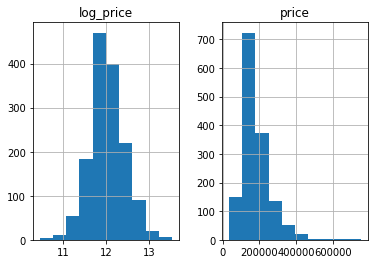

In [109]:
%matplotlib inline
prices.hist()

**The aim is to normalize the label data to gaussian distribution**

### 分析feature的各个列

 - 首先将train和test的样本数据进行合并

In [110]:
all_df = pd.concat((train_df,test_df),axis=0)
# a = all_df.pop('Id')
all_df.shape

(2919, 79)

- pandas会默认将数值型的数值转为numeric，需要将对应的列转为正确的类型

In [111]:
all_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


In [112]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [113]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

In [114]:
# 对该列数据进行One-hot方法分成多列的数值0or1的表示
pd.get_dummies(all_df['MSSubClass'],prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [115]:
# make use of one-hot to convert all the object types(categories columns) into numeric columns
all_dummy_df = pd.get_dummies(all_df)

 ### 空值处理

 - 空值统计

In [116]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

 - 使用均值(average value)来处理这些值

In [117]:
 # 获取每列的均值
mean_cols = all_dummy_df.mean(axis=0)
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [118]:
# 采用每列的均值填充该列的空值
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [119]:
# 检查是否还有空值
all_dummy_df.isnull().sum(axis=0).sum()

0

## 标准化numeric的数值列

 - 首先找到所有的数值列

In [120]:
numric_cols = all_df.columns[all_df.dtypes != 'object']

In [121]:
# 求得每个数值列的平均值
num_mean_cols = all_df.loc[:,numric_cols].mean(axis=0)

# 求标准方差
num_std_cols = all_df.loc[:,numric_cols].std(axis=0)

In [122]:
# 标准化
all_dummy_df.loc[:,numric_cols] = (all_dummy_df.loc[:,numric_cols] - num_mean_cols) / num_std_cols

# 建立模型

 - 将整个数据集分为train和test 数据集

In [123]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [124]:
dummy_train_df.shape,dummy_test_df.shape

((1460, 303), (1459, 303))

 - Ridge regression

In [125]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [126]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values
y_train = np.log1p(y_train)

In [127]:
alphas = np.logspace(start=-3,stop=2,num=50,base=10)
test_scores = []
for alpha in alphas:
    cls = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(estimator=cls,X=X_train,y=y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

test_scores

[0.15324561793329955,
 0.15321658953968789,
 0.15318247413997227,
 0.15314054371448638,
 0.15308812028741595,
 0.15302264226033938,
 0.15294165596128462,
 0.15284274566860753,
 0.15272341610524801,
 0.15258094436723854,
 0.15241222723958539,
 0.15221366162545075,
 0.15198110282139279,
 0.15170994169369961,
 0.15139532720015508,
 0.15103253849320691,
 0.15061748220733076,
 0.15014725307966839,
 0.14962065114466494,
 0.14903851194334988,
 0.14840370905097658,
 0.14772076311538179,
 0.1469951419768345,
 0.14623250986644876,
 0.14543827675563478,
 0.1446177147316631,
 0.14377664256582026,
 0.14292236152012053,
 0.14206435076962393,
 0.14121432113112892,
 0.14038552969215168,
 0.13959158583405798,
 0.13884514595618944,
 0.13815684973932468,
 0.13753468918286391,
 0.13698385375551264,
 0.13650701647142716,
 0.13610498353192801,
 0.1357775757450182,
 0.13552454476021489,
 0.13534629878573368,
 0.135244262098692,
 0.13522081435790329,
 0.1352788990926091,
 0.13542149437539258,
 0.1356511648707

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Alpha VS CV')

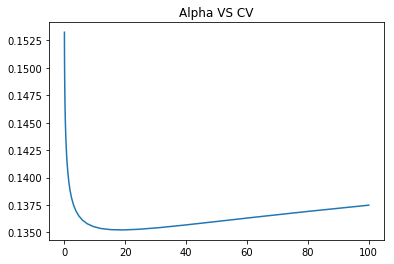

In [130]:
plt.plot(alphas,test_scores)
plt.title("Alpha VS CV")

**从上面可以看出alpha的值大约在15的时候，损失函数最小**

# 使用随机森林(random forest)来强化预测功能

In [132]:
from sklearn.ensemble import RandomForestRegressor

In [138]:
def get_cv_mean_score(max_feats):
    if max_feats is not None:
        max_features = max_feats
    else:
        max_features = [0.1,0.3,0.5,0.7,0.9,0.99]
    test_scores = []

    for max_feat in max_features:
        clf = RandomForestRegressor(bootstrap=True,n_estimators=200,max_features=max_feat)
        test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
        test_scores.append(np.mean(test_score))
    return test_scores

Text(0.5,1,'Max feature vs CV error')

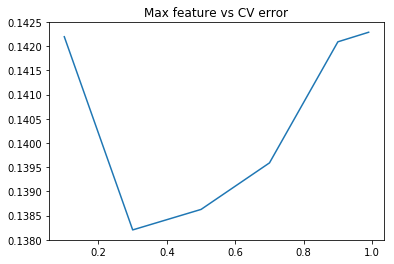

In [139]:
test_scores = get_cv_mean_score([0.1,0.3,0.5,0.7,0.9,0.99])
plt.plot([0.1,0.3,0.5,0.7,0.9,0.99],test_scores)
plt.title('Max feature vs CV error')

**from the above we can see that when choose 30% of features we would come to the smallest error score.**

**We will choose 0.2 to 0.5 to see if there is another better percent than 03**

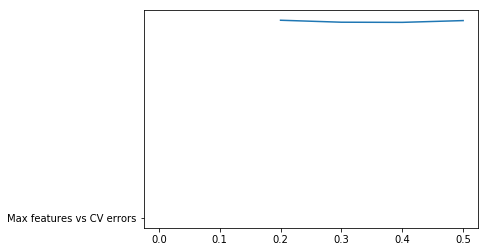

In [141]:
max_features = [0.2,0.3,0.4,0.5]
test_scores = get_cv_mean_score(max_features)

plt.plot(max_features,test_scores)
plt.plot('Max features vs CV errors')

In [143]:
test_scores

[0.1385220187501186,
 0.13713978361477094,
 0.13704146592211025,
 0.13828099970856775]

# Predict

In [144]:
rf = Ridge(alpha=15)
rf_clf = rf.fit(X_train,y_train)
rf_y = np.expm1(rf_clf.predict(X_test))

rd = RandomForestRegressor(n_estimators=200,max_features=0.4)
rd_clf = rd.fit(X_train,y_train)
rd_y = np.expm1(rd_clf.predict(X_test))

p_y = (rf_y + rd_y) / 2.0

# commit the result

In [146]:
submission_df = pd.DataFrame(data= {'Id' : test_df.index, 'SalePrice': p_y})
submission_df.head()

,Id,SalePrice
0,1461,119449.189391
1,1462,151575.810370
2,1463,173606.977039
3,1464,188717.805669
4,1465,194647.066994
